In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output

In [22]:
batchSize= 32
imgSize= 256
rgbChannels= 3
EPOCHS= 60

In [4]:
datasets= tf.keras.preprocessing.image_dataset_from_directory(
    "../datasets/chest_classification/covid/",
    seed= 128,
    shuffle= True,
    image_size= (imgSize, imgSize),
    batch_size= batchSize
)

Found 3091 files belonging to 2 classes.


In [6]:
clsNames= datasets.class_names
clsNames

['0', '1']

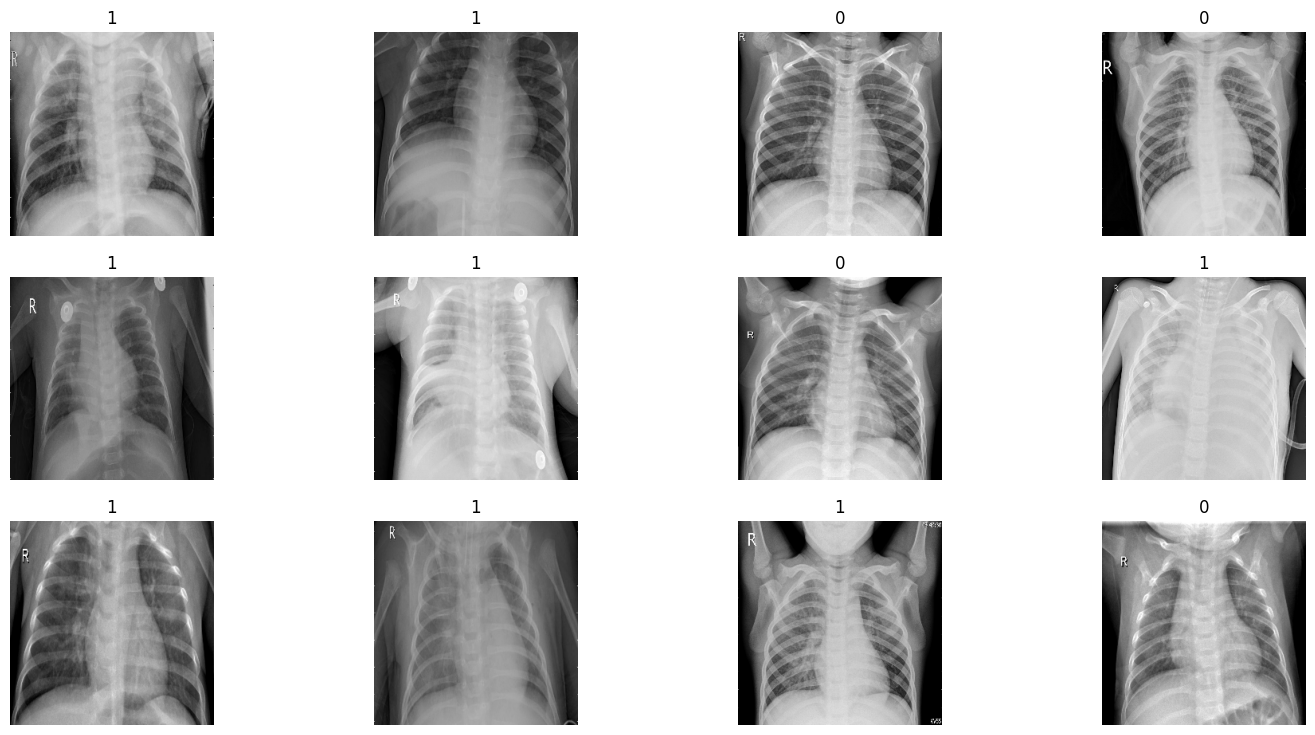

In [7]:
plt.figure(figsize= (18, 9))
for imageBatch, labelBatch in datasets.take(1):
    for i in range(12):
        ax= plt.subplot(3, 4, i+1)
        plt.imshow(imageBatch[i].numpy().astype("uint8"))
        plt.title(datasets.class_names[labelBatch[i]])
        plt.axis("off")

In [8]:
def getSplittedDS(ds, trainSplit= 0.8, testSplit= 0.1, valSplit= 0.1, shuffle= True, shuffleSize= 10000):
    assert (trainSplit + testSplit + valSplit) == 1
    
    dsSize= len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffleSize, seed= 12)
        
    trainSize= int(trainSplit*dsSize)
    valSize= int(valSplit*dsSize)
    
    trainDS= ds.take(trainSize)
    valDS= ds.skip(trainSize).take(valSize)
    testDS= ds.skip(trainSize).skip(valSize)
    
    return trainDS, valDS, testDS

In [9]:
trainDS, valDS, testDS= getSplittedDS(datasets)

In [10]:
len(datasets)

97

In [11]:
trainDS= trainDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
testDS= testDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
valDS= valDS.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)

In [12]:
dataAugmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
resizeRescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imgSize, imgSize),
    layers.experimental.preprocessing.Rescaling(1/255)
])

In [12]:
trainDS= trainDS.map(lambda x, y: (dataAugmentation(x, training= True), y)).prefetch(buffer_size= tf.data.AUTOTUNE)

In [23]:
inpShape= batchSize, imgSize, imgSize, rgbChannels

model= models.Sequential([
    dataAugmentation,
    resizeRescale,
    layers.Conv2D(32, (3, 3), activation= 'relu', input_shape= (inpShape)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation= 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation= 'relu'),
    layers.Dense(32, activation= 'relu'),
    layers.Dense(2, activation= 'softmax')
])

model.build(input_shape= inpShape)

In [24]:
model.compile(optimizer= 'adam', loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), metrics= ['accuracy'])

In [25]:
history= model.fit(trainDS, validation_data= valDS, verbose= 1, epochs= EPOCHS)

Epoch 1/60
77/77 [==============================] - 19s 215ms/step - loss: 0.6849 - accuracy: 0.5749 - val_loss: 0.6893 - val_accuracy: 0.5486
Epoch 2/60
77/77 [==============================] - 14s 187ms/step - loss: 0.5897 - accuracy: 0.7128 - val_loss: 0.8296 - val_accuracy: 0.5799
Epoch 3/60
77/77 [==============================] - 14s 186ms/step - loss: 0.3708 - accuracy: 0.8572 - val_loss: 0.2643 - val_accuracy: 0.8958
Epoch 4/60
77/77 [==============================] - 15s 189ms/step - loss: 0.2438 - accuracy: 0.9119 - val_loss: 0.2367 - val_accuracy: 0.9201
Epoch 5/60
77/77 [==============================] - 14s 188ms/step - loss: 0.2484 - accuracy: 0.9053 - val_loss: 0.1933 - val_accuracy: 0.9340
Epoch 6/60
77/77 [==============================] - 14s 186ms/step - loss: 0.2036 - accuracy: 0.9262 - val_loss: 0.1893 - val_accuracy: 0.9410
Epoch 7/60
77/77 [==============================] - 14s 186ms/step - loss: 0.1992 - accuracy: 0.9302 - val_loss: 0.2654 - val_accuracy: 0.8924

In [27]:
score= model.evaluate(testDS.take(1))

1/1 [==============================] - 0s 356ms/step - loss: 0.1663 - accuracy: 0.9062


In [28]:
acc= history.history['accuracy']
valAccuracy= history.history['val_accuracy']

loss= history.history['loss']
valLoss= history.history['val_loss']

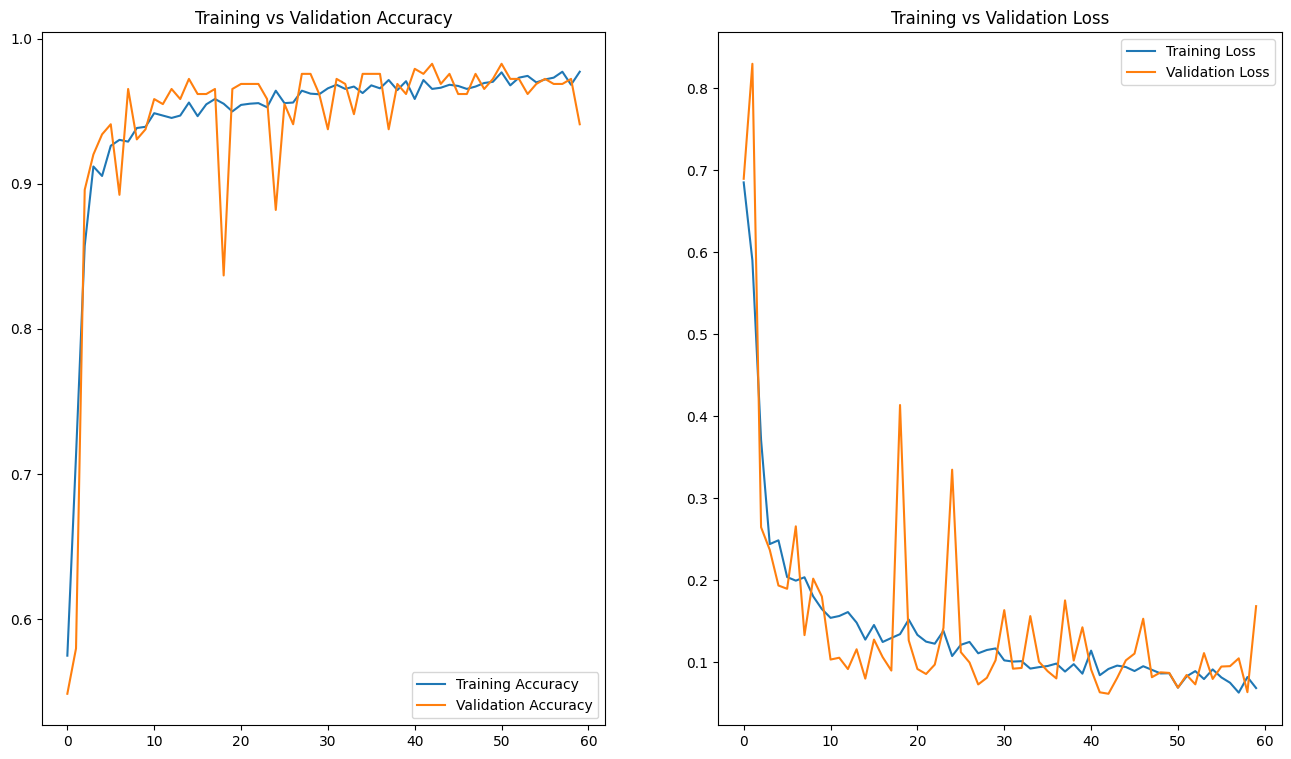

In [29]:
plt.figure(figsize= (16, 9))
plt.subplot(1, 2, 1)
sns.lineplot(x= range(EPOCHS), y=acc, label= 'Training Accuracy')
plt.title('Training vs Validation Accuracy')
sns.lineplot(x= range(EPOCHS), y=valAccuracy, label= 'Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x= range(EPOCHS), y=loss, label= 'Training Loss')
plt.title('Training vs Validation Loss')
sns.lineplot(x= range(EPOCHS), y=valLoss, label= 'Validation Loss')
plt.legend()
plt.show()

In [30]:
def predFunc(model, img):
    imgArray= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    imgArray= tf.expand_dims(imgArray, 0)
    
    predictions= model.predict(imgArray)
    
    predictedClass= clsNames[np.argmax(predictions[0])]
    confidence= round((100*(np.max(predictions[0]))), 2)
    
    return predictedClass, confidence

1/1 [==============================] - 0s 26ms/step


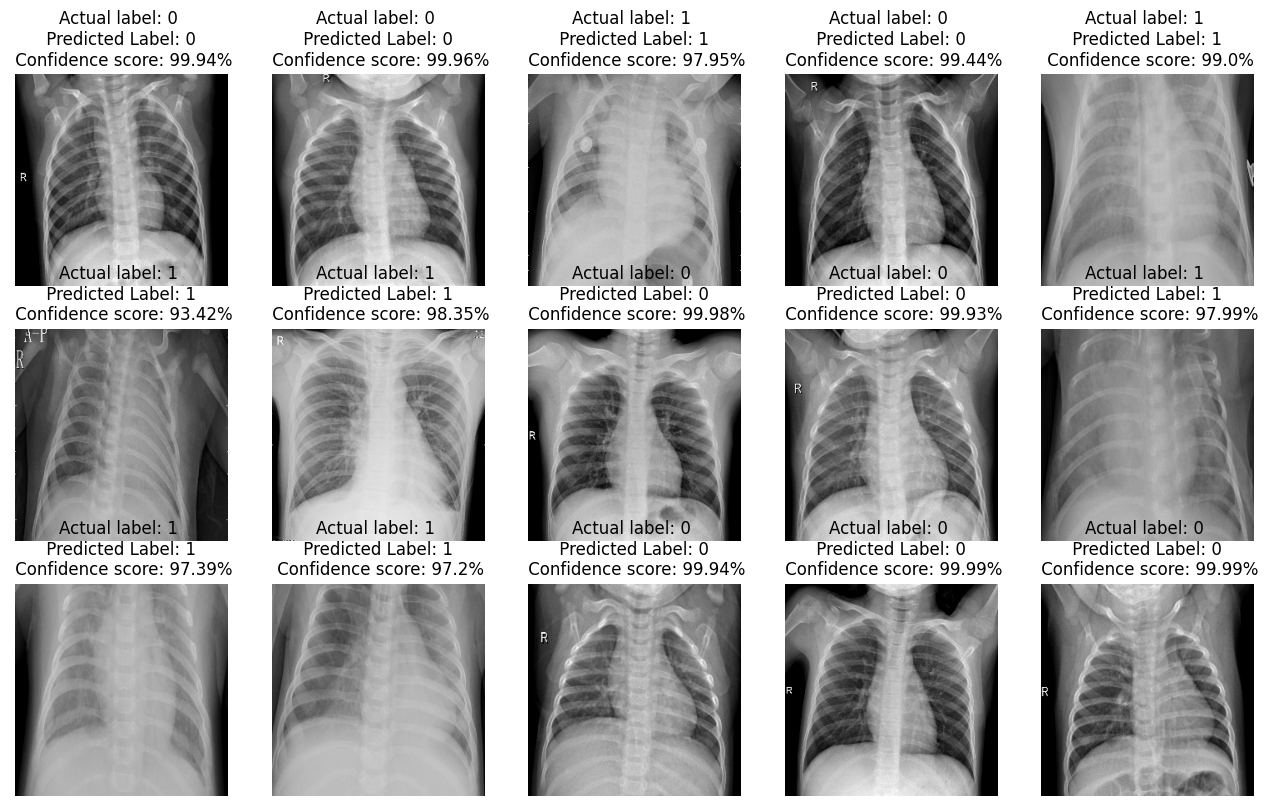

In [33]:
plt.figure(figsize= (16, 16))

for images, labels in testDS.take(1):
    for i in range(15):
        ax= plt.subplot(5, 5, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predictedCls, confidence= predFunc(model, images[i].numpy())
        actualCls= clsNames[labels[i]]
                
        plt.title(f"Actual label: {actualCls} \n Predicted Label: {predictedCls} \n Confidence score: {confidence}%")        
        plt.axis('off')

In [34]:
converter= tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model= converter.convert()

with open('../exports/covidV1.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmptcd9k5c2\assets


INFO:tensorflow:Assets written to: C:\Users\Rohan\AppData\Local\Temp\tmptcd9k5c2\assets
